# Knapsack Solution Visualization

In [1]:
# set work dir if PyEPO is not installed
import os
os.chdir("../pkg")

In this study, we utilize a technique of visualizing predicted-then-optimized results in order to gain an intuitive understanding of the performance variations among the various approaches.

In this study, the knapsack problem is utilized as an exemplar.  The knapsack problem is a combinatorial optimization problem that seeks to find the most valuable set of items to include in a knapsack, subject to constraints on the total weight of the items. 

## 1 Preparation

### 1.1 Libraries

Import useful libraries.

In [2]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm

Auto-Sklearn cannot be imported.


In [3]:
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

### 1.2 Visulization Function

Define a function that visualizes the result of the predict-then-optimize knapsack.

In [4]:
# plot function
def plotSol(m, c, w, weights, caps, caption=None):
    # colors
    cmap = cm.get_cmap("plasma")(np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2 = [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        cap2.append(weights[1,i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0, 0]
    # bar plot
    for i in range(m):
        bar = [sol[i], val[i], cap1[i], cap2[i]]
        plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
        # not selected
        if not int(w[i]):
            # grey color
            bar = [sol[i], 0, 0, 0]
            plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
            plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
        acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i], acc[3]+cap2[i]]
    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=12)
    # vertical line
    plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
    plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=12, color="firebrick")
    plt.axvline(x=caps[1], ymin=0.03, ymax=0.24, color="firebrick", linewidth=1.5)
    plt.text(caps[1]+0.5, 3.1, "Capacity 2", fontsize=12, color="firebrick")
    # labels and ticks
    plt.xticks([])
    plt.yticks(range(4), ["Items Selection", "Items Value", "Resource 1", "Resource 2"], fontsize=16)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=18)
    plt.show()
    return fig

### 1.3 Optimization Model, Dataset and Data Loader

#### Dataset

PyTorch provides ``Dataset`` to stores the samples $\mathbf{x}$ and their corresponding costs $\mathbf{c}$. Besides storing $\mathbf{x}$ and $\mathbf{c}$, ``optDataset`` uses solver to find the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [5]:
# generate data for 2D knapsack
m = 16 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

#### Optimization Model

We load ``pyepo.model.grb.knapsackModel`` as MIP model for the knapsack problem. For more details on ``optModel``, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [6]:
optmodel = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


#### Data Loader

``DataLoader`` wraps an iterable around the Dataset to enable easy access to the samples.

In [7]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 671.15it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 747.37it/s]


In [9]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

### 1.4 PyTorch Linear Regression

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, linear regression.

In [10]:
from torch import nn
# build linear model
class LinearRegressionNN(nn.Module):
    
    def __init__(self):
        super(LinearRegressionNN, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## 2 Solution Visualization

We present a visual representation of solutions to the knapsack problem obtained from a variety of methods. All apply to the same instance of the problem. The visualization includes four rows, with the first row depicting the items selected, the second row depicting the corresponding total values, and the last two rows displaying the capacity constraints. This visual representation serves to provide an intuitive understanding of the solutions obtained through the different methods.

In [11]:
# a index of arbitrary instance to visualize
ind = 0

### 2.1 Optimal Solution 

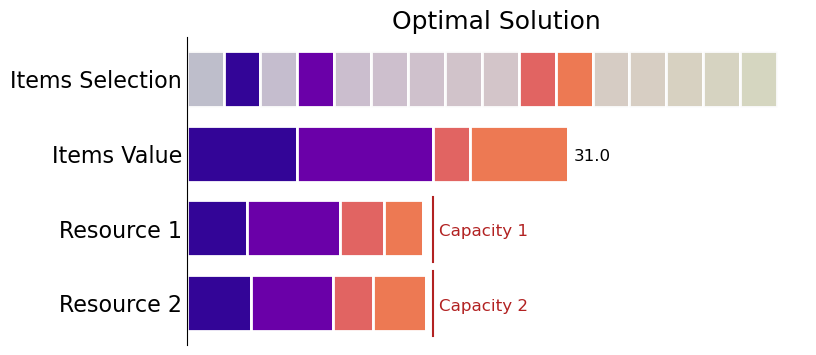

In [12]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # convert to numpy
    x = x.to("cpu").detach().numpy()[0]
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    if i == ind:
        fig = plotSol(m, c, w, weights, caps, "Optimal Solution")
        break

### 2.2 Two-Stage with Linear Regression 

In [13]:
from sklearn.linear_model import LinearRegression
# prediction model
reg = LinearRegression()
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [14]:
# training
twostage_model.fit(dataset_train.feats, dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

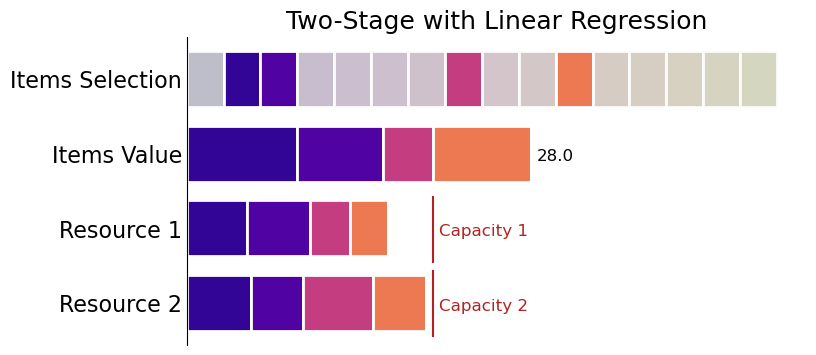

In [15]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    # predict
    cp = twostage_model.predict(x)
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c, wp, weights, caps, "Two-Stage with Linear Regression")
        break

### 2.3 SPO+

In [16]:
# init model
reg = LinearRegressionNN()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [17]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=1)
# train model
num_epochs = 20
reg.train()
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # spo+ loss
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
# regret
regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

Num of cores: 1
Epoch   0, Loss:  36.4385, Regret: 34.9755%
Epoch   5, Loss:  34.7859, Regret: 21.0182%
Epoch  10, Loss:  14.6159, Regret: 12.7163%
Epoch  15, Loss:   8.1044, Regret:  9.5466%
Epoch  19, Loss:  13.6386, Regret:  8.3393%


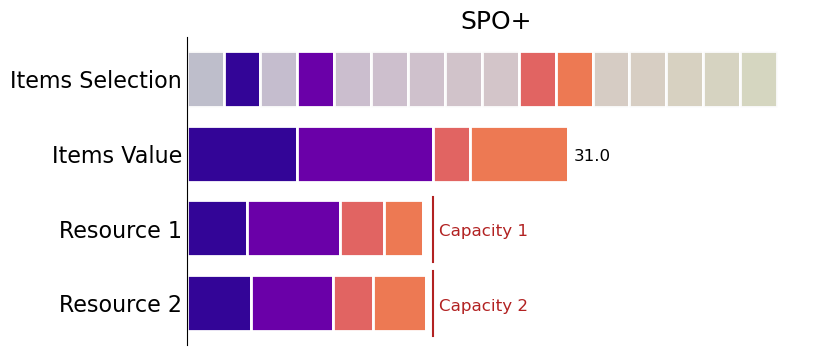

In [18]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    cp = cp.to("cpu").detach().numpy()
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c, wp, weights, caps, "SPO+")
        break

### 2.4 DBB 

In [19]:
# init model
reg = LinearRegressionNN()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [20]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)
# init dbb
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=1) 
# set loss
l1 = nn.L1Loss()
# train model
num_epochs = 20
reg.train()
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # regret loss
        loss = l1(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
# regret
regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

Num of cores: 1
Epoch   0, Loss:   8.2500, Regret: 42.7503%
Epoch   5, Loss:   9.2500, Regret: 29.3425%
Epoch  10, Loss:   2.0000, Regret: 22.4722%
Epoch  15, Loss:   1.5000, Regret: 18.0653%
Epoch  19, Loss:   7.7500, Regret: 16.6150%


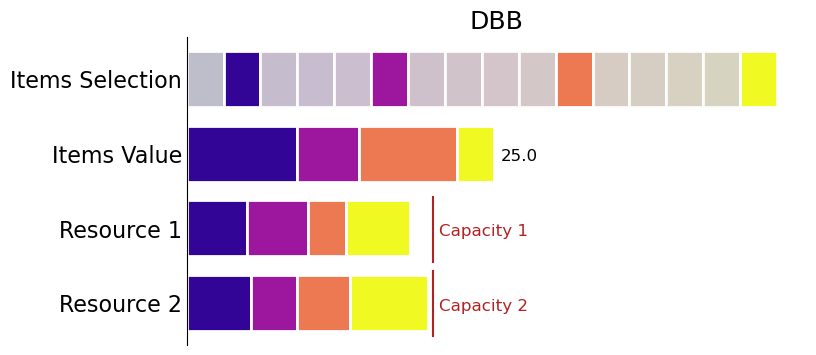

In [21]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    cp = cp.to("cpu").detach().numpy()
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c, wp, weights, caps, "DBB")
        break

### 2.5 DPO

In [22]:
# init model
reg = LinearRegressionNN()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [23]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
# init ptb
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=10, epsilon=0.5, processes=1)
# set loss
l2 = nn.MSELoss()
# train model
num_epochs = 20
reg.train()
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # perturbed optimizer
        we = ptb(cp)
        # loss
        loss = l2(we, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
# regret
regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

Num of cores: 1
Epoch   0, Loss:   0.2561, Regret: 47.6283%
Epoch   5, Loss:   0.1834, Regret: 32.5085%
Epoch  10, Loss:   0.1291, Regret: 25.2196%
Epoch  15, Loss:   0.1833, Regret: 22.0162%
Epoch  19, Loss:   0.1034, Regret: 19.1829%


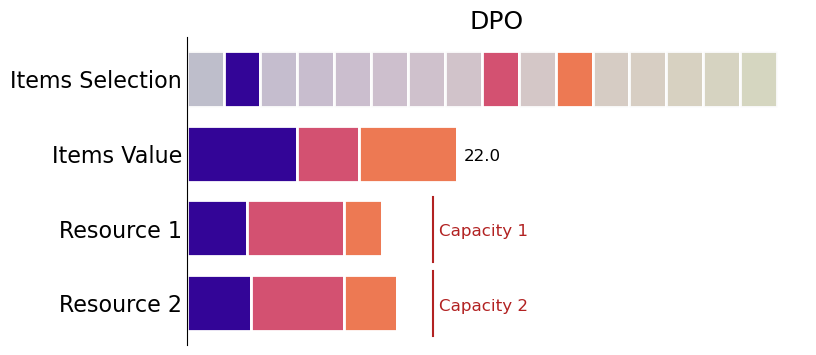

In [24]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    cp = cp.to("cpu").detach().numpy()
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c, wp, weights, caps, "DPO")
        break

### 2.6  PFYL

In [25]:
# init model
reg = LinearRegressionNN()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
# init PFY Loss
fyloss = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, epsilon=0.5, processes=1)
# train model
num_epochs = 20
reg.train()
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # loss
        loss = fyloss(cp, w).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
# regret
regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

Num of cores: 1
Epoch   0, Loss:   1.8775, Regret: 21.4705%
Epoch   5, Loss:   1.1525, Regret:  8.7542%
Epoch  10, Loss:   0.7475, Regret:  8.5523%
Epoch  15, Loss:   1.2425, Regret:  8.3355%
Epoch  19, Loss:   1.5625, Regret:  8.4177%


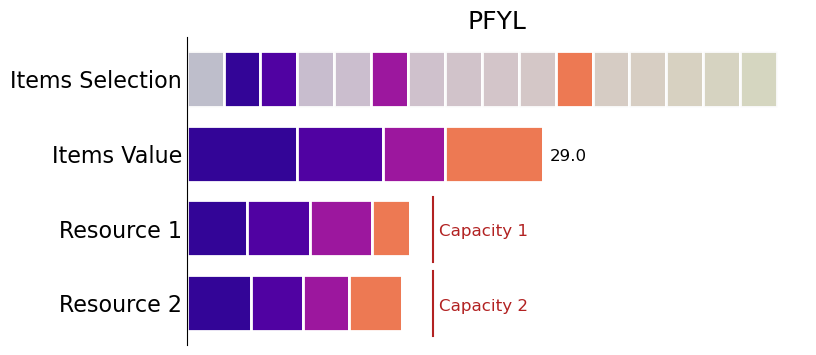

In [27]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    cp = cp.to("cpu").detach().numpy()
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c, wp, weights, caps, "PFYL")
        break